In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.utils import save_image

import torch.optim as optim


import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math


import os 
import glob
import time
import cv2

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import imageio

In [2]:
#%matplotlib qt
#%matplotlib inline

In [3]:
img_height = 256
img_width = 256

In [4]:
lpdf = pd.read_csv("./trainVal.csv")
image_path = lpdf['image_path'][0]
image_path

'./crop_m1/I00000.png'

In [5]:
for i in range(652//2):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #opencv reads assuming bgr, bgr^2 = rgb hehe
    img = cv2.resize(img, (img_width, img_height))
    
    break
    

In [6]:
type(img)

numpy.ndarray

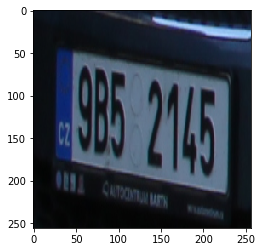

In [7]:
%matplotlib inline
q1 = torch.tensor(img)
plt.imshow(q1.permute(2,1,0).permute(2,1,0)) #imshow inputs H,W,C; pytorch conv2d inputs C,H,W


In [8]:
img.shape


(256, 256, 3)

In [10]:
#TRYING TO ENHANCE EDGE DETECTION RESULT
#https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html

In [11]:
#converting grayscale to 3 channel
q2tch = torch.stack((q2, q2, q2),2)
q2tch.shape


torch.Size([256, 256, 3])

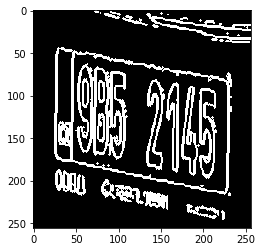

In [12]:
dilation_factor = 0.5
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
plt.imshow(cv2.dilate(q2tch.numpy(), kernel))

In [79]:
(lpdf['image_path'][4])

'./crop_m1/I00002.png'

In [83]:
def make_training_images(save_path = "./edgePhotoPairsColourBalancedOnly2/", img_height = 256, img_width = 256, canny_thresholds = (96, 96)):
    
    
    try:
        os.mkdir(save_path)
    
    except Exception as e:
        print('Mkdir failed. %s. Reason: %s' % (save_path, e))
    
    
    lp_df = pd.read_csv("./trainVal.csv")
    
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
    
    for i in range(652):
        
        #the even index images are same as odd index ones but colour balanced i think
        if(i%2 == 0):
            
            image_path = lp_df['image_path'][i]

            img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #opencv reads assuming bgr, bgr^2 = rgb hehe
            img = cv2.resize(img, (img_width, img_height))

            q1 = img
            q2 = cv2.Canny(q1, canny_thresholds[0], canny_thresholds[1])
            q2 = np.stack((q2, q2, q2), 2)
            q2 = cv2.dilate(q2, kernel)   
            
            q1fh = cv2.flip(q1, 1)
            q2fh = cv2.flip(q2, 1)
            
            q1fv = cv2.flip(q1, 0)
            q2fv = cv2.flip(q2, 0)
            
            q1fhv = cv2.flip(q1, -1)
            q2fhv = cv2.flip(q2, -1)
            
            q = np.concatenate((q2, q1), 1)
            qfh = np.concatenate((q2fh, q1fh), 1)
            qfv = np.concatenate((q2fv, q1fv), 1)
            qfhv = np.concatenate((q2fhv, q1fhv), 1)

            img_name = str(lp_df['lp'][i])
            #print(save_path + img_name + ".png")
            
            img_save_path = save_path + img_name + ".png"
            img_save_path_fh = save_path + img_name + "_fh.png"
            img_save_path_fv = save_path + img_name + "_fv.png"
            img_save_path_fhv = save_path + img_name + "_fhv.png"

            imageio.imwrite(img_save_path, q)
            imageio.imwrite(img_save_path_fh, qfh)
            imageio.imwrite(img_save_path_fv, qfv)
            imageio.imwrite(img_save_path_fhv, qfhv)
            

        


In [84]:
#%matplotlib qt
make_training_images()

Mkdir failed. ./edgePhotoPairsColourBalancedOnly/. Reason: [WinError 183] Cannot create a file when that file already exists: './edgePhotoPairsColourBalancedOnly/'


In [85]:
help(imageio.imwrite)

Help on function imwrite in module imageio.core.functions:

imwrite(uri, im, format=None, **kwargs)
    imwrite(uri, im, format=None, **kwargs)
    
    Write an image to the specified file.
    
    Parameters
    ----------
    uri : {str, pathlib.Path, file}
        The resource to write the image to, e.g. a filename, pathlib.Path
        or file object, see the docs for more info.
    im : numpy.ndarray
        The image data. Must be NxM, NxMx3 or NxMx4.
    format : str
        The format to use to read the file. By default imageio selects
        the appropriate for you based on the filename and its contents.
    kwargs : ...
        Further keyword arguments are passed to the writer. See :func:`.help`
        to see what arguments are available for a particular format.



In [86]:
print(glob.glob("./edgePhotoPairsColourBalancedOnly/*")[0])

./edgePhotoPairsColourBalancedOnly\1AT5828.png


In [5]:
def make_training_data(image_pairs_path = "./edgePhotoPairsColourBalancedOnly/"):
    
    
    try:
        os.mkdir(image_pairs_path)
    
    except Exception as e:
        print('Mkdir failed. %s. Reason: %s' % (image_pairs_path, e))
    
    
  
    real_pairs = []
    
    for i in glob.glob("./edgePhotoPairsColourBalancedOnly/*"):           
    
        img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #opencv reads assuming bgr, bgr^2 = rgb hehe

        img = img.transpose(2,0,1) #channels, height, width
        imgO = img[:,:,:256]
        imgR = img[:,:,256:]
        img = np.concatenate((imgR, imgO), 0) #outlines index 3 onwards         
   
        real_pairs.append(img)
        
    np.random.shuffle(real_pairs)    
    np.save("real_pairs.npy", real_pairs)
        

In [6]:
make_training_data()


Mkdir failed. ./edgePhotoPairsColourBalancedOnly/. Reason: [WinError 183] Cannot create a file when that file already exists: './edgePhotoPairsColourBalancedOnly/'


(3, 256, 256)
(3, 256, 256)
(6, 256, 256)


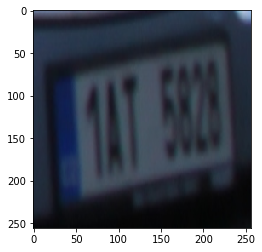

In [3]:
 for i in glob.glob("./edgePhotoPairsColourBalancedOnly/*"):           
    
        img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #opencv reads assuming bgr, bgr^2 = rgb hehe

        #plt.imshow(img.transpose(2,0,1).transpose(1,2,0)) #imshow takes in height, width, channel

        img = img.transpose(2,0,1) #channels, height, width
        imgR= img[:,:,:256]
        imgO = img[:,:,256:]
        print(imgO.shape)
        print(imgR.shape)
        img = np.concatenate((imgO, imgR), 0)
        print(img.shape)
        plt.imshow(img[:3,:,:].transpose(1,2,0))
        break

In [7]:
data = torch.tensor(np.load("real_pairs.npy")).float()

In [8]:
dataNormalised = (data - 127.5)/127.5

In [9]:
np.save("real_pairs.npy",dataNormalised.numpy())

#data is colour balanced, shuffled, normalised, augmented with flips